In [1]:
import pysd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math


### Determine Directory

In [2]:
vensimDirectory='./Simulation Files/Prosumers & defectors'
vensimFile ='net metering-no fixed tariff.mdl'
filepath = Path(vensimDirectory,vensimFile)
model = pysd.read_vensim(str(filepath))

### Parameters

In [38]:
step_range=[(s,2**-s) for s in range(7,11)]
paramaters={
    'population growth rate':0.001,
    'time to adjust Prosumer Demand':1,
    'time to adjust Regular Consumer demand':1,
    'Tariff Correction Period':1
    # 'price elasticity of prosumers':0,
    # 'price elasticity of regular consumers':0
}


## Simulation
run the model and check the effect of time step

In [4]:
result={}
for _,s in step_range:
    result[s] = model.run(params={**paramaters, 'TIME STEP':s , 'SAVEPER':step_range[0]})

In [39]:
base=result[step_range[len(step_range)-1][1]].astype('float64')
error=pd.DataFrame()
for i,s in step_range:
    print(f'{i}:{s}')
    current=result[s].astype('float64')
    ind=(((base-result[s])/base).abs()['Monthly Income Shortfall'].idxmax(axis=0)).astype('float64')
    # ind=error.idxmax()
    print(f'{ind}-- base: {base.loc[ind,"Monthly Income Shortfall"]}, value:{result[s].loc[ind,"Monthly Income Shortfall"]}')
    # print(f'error:{error}, type:{type(error)}')


7:0.0078125
227.3359375-- base: 0.19977423548698425, value:22418.205514431
8:0.00390625
227.3359375-- base: 0.19977423548698425, value:8710.622028291225
9:0.001953125
227.3359375-- base: 0.19977423548698425, value:2767.7522698044777
10:0.0009765625
0.0-- base: -1000000.0, value:-1000000.0


In [15]:
# important_vars=['Electricity Tariff','Desired Income','Income','Monthly Income Shortfall','Budget Deficit', 'Utility Energy Sale','NPV PV','Total Consumers','Defectors','Regular Consumers','Prosumers','Regular Consumer Average Demand', 'Prosumer Average Demand','Regular Consumers Demand','Prosumers Demand']
important_vars=['Electricity Tariff','Income','Monthly Income Shortfall','Budget Deficit' ]

In [40]:
select_result={v:pd.DataFrame() for v in important_vars}   
for i,s in step_range[:]:
    for v in important_vars:
        select_result[v][i]=result[s][v].astype('float64')

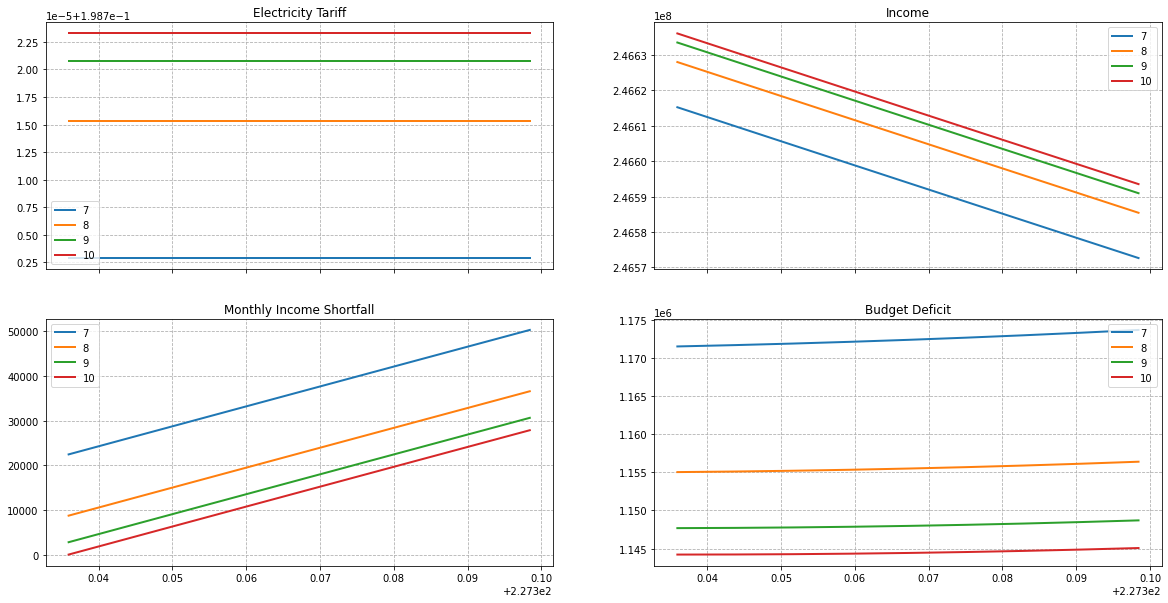

In [41]:
mpl.rc('lines',linewidth=2)  
n_rows= math.ceil(len(important_vars)/2)
fig,ax =plt.subplots(n_rows,2,sharex=True)
fig.set_size_inches(20,n_rows*5)
for i,v in enumerate(important_vars):
    cur_ax=ax[i//2,i%2]
    select_result[v].loc[227.33:227.4,:].plot(ax=cur_ax)
    cur_ax.grid(True,linestyle='--')
    cur_ax.title.set_text(v)